/opt/anaconda3/lib/python3.13/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


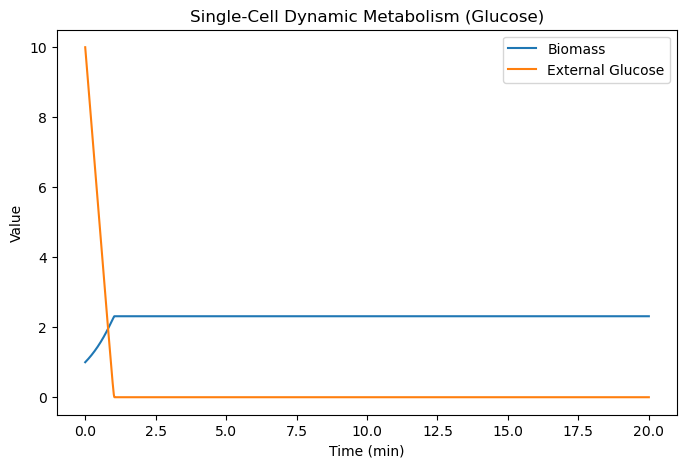

In [55]:
from cobrapy_bigg_client import client
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------
# Load the E. coli core model
# --------------------------------------
model = client.download_model("e_coli_core", save=False)

# Biomass reaction (verified earlier)
biomass_rxn = model.reactions.get_by_id("BIOMASS_Ecoli_core_w_GAM")

# Make biomass irreversible (biologically correct)
biomass_rxn.lower_bound = 0


# =====================================================================================
# STEP 1: CLOSE ALL EXCHANGE REACTIONS
# =====================================================================================
for rxn in model.exchanges:
    rxn.lower_bound = 0  # no uptake allowed initially


# =====================================================================================
# STEP 2: DEFINE MINIMAL MEDIUM WITH ONLY NECESSARY NUTRIENTS
# =====================================================================================
# Your model contains these exchange reactions:
# EX_glc__D_e, EX_o2_e, EX_nh4_e, EX_pi_e, EX_h2o_e, EX_h_e

# Allow carbon, nitrogen, phosphate, oxygen
model.reactions.EX_glc__D_e.lower_bound = -10      # glucose
model.reactions.EX_o2_e.lower_bound    = -20       # oxygen
model.reactions.EX_nh4_e.lower_bound   = -10       # ammonium / nitrogen
model.reactions.EX_pi_e.lower_bound    = -10       # phosphate
model.reactions.EX_h2o_e.lower_bound   = -1000     # water (always abundant)
model.reactions.EX_h_e.lower_bound     = -1000     # protons


# =====================================================================================
# STEP 3: DISABLE ALL ALTERNATIVE CARBON SOURCES
# =====================================================================================
alt_c_sources = [
    "EX_ac_e", "EX_acald_e", "EX_akg_e", "EX_etoh_e",
    "EX_for_e", "EX_fru_e", "EX_fum_e", "EX_glu__L_e",
    "EX_lac__D_e", "EX_mal__L_e", "EX_pyr_e", "EX_succ_e"
]

for rid in alt_c_sources:
    if rid in model.reactions:
        model.reactions.get_by_id(rid).lower_bound = 0


# =====================================================================================
# STEP 4: SINGLE-CELL INITIAL CONDITIONS
# =====================================================================================
biomass = 1.0         # arbitrary biomass
glucose = 10.0        # external glucose pool
dt = 0.001              # time step
T  = 20              # total simulated time
time = np.arange(0, T, dt)

biomass_trace = []
glucose_trace = []
mu_trace = []


# =====================================================================================
# STEP 5: MAIN DYNAMIC FBA LOOP
# =====================================================================================
# Define the half-saturation constant (Km)
# Real E. coli Km is ~0.001-0.01 mM, but we use 0.5 here so you can SEE the curve smoothing
Km = 0.05   # realistic half-saturation

for t in time:

    # Monod-limited uptake
    v_max = 10.0
    monod_rate = v_max * (glucose / (Km + glucose))

    # Physical mass-balance limit
    max_possible_uptake = glucose / dt   # fixes incorrect scaling

    # Actual bound
    actual_bound = min(monod_rate, max_possible_uptake)
    model.reactions.EX_glc__D_e.lower_bound = -actual_bound

    # Solve FBA
    sol = model.optimize()

    if sol.status != "optimal":
        mu = 0
        uptake = 0
    else:
        mu = sol.fluxes["BIOMASS_Ecoli_core_w_GAM"]
        uptake = -sol.fluxes["EX_glc__D_e"]

    # Stop growth if glucose depleted
    if glucose <= 1e-9:
        mu = 0
        uptake = 0

    # Update biomass
    biomass += mu * biomass * dt

    # Correct update equation (no biomass multiplication)
    glucose -= uptake * dt
    glucose = max(glucose, 0)

    biomass_trace.append(biomass)
    glucose_trace.append(glucose)
    mu_trace.append(mu)


# =====================================================================================
# STEP 6: PLOT RESULTS
# =====================================================================================
plt.figure(figsize=(8,5))
plt.plot(time, biomass_trace, label="Biomass")
plt.plot(time, glucose_trace, label="External Glucose")
plt.xlabel("Time (min)")
plt.ylabel("Value")
plt.title("Single-Cell Dynamic Metabolism (Glucose)")
plt.legend()
plt.show()


/opt/anaconda3/lib/python3.13/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


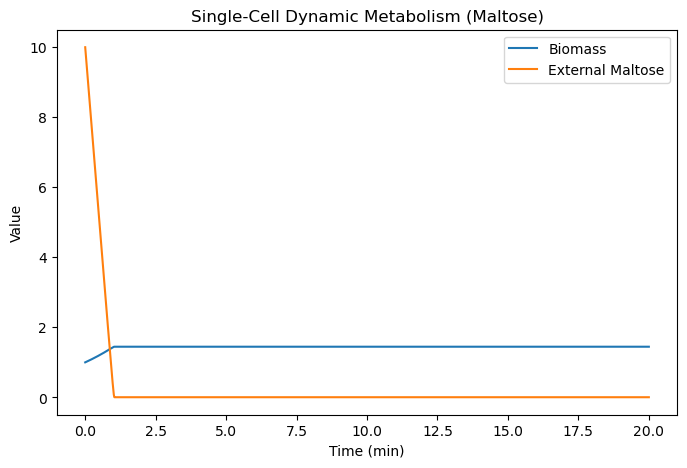

In [56]:
# --------------------------------------
# BIOMASS
# --------------------------------------
biomass_rxn = model.reactions.get_by_id("BIOMASS_Ecoli_core_w_GAM")
biomass_rxn.lower_bound = 0

# --------------------------------------
# CLOSE ALL EXCHANGES
# --------------------------------------
for rxn in model.exchanges:
    rxn.lower_bound = 0

# --------------------------------------
# MINIMAL MEDIUM — MALTose ONLY
# --------------------------------------
model.reactions.EX_mal__L_e.lower_bound = -10   # maltose as sole carbon
model.reactions.EX_o2_e.lower_bound     = -20
model.reactions.EX_nh4_e.lower_bound    = -10
model.reactions.EX_pi_e.lower_bound     = -10
model.reactions.EX_h2o_e.lower_bound    = -1000
model.reactions.EX_h_e.lower_bound      = -1000

# --------------------------------------
# DISABLE ALL OTHER CARBON SOURCES
# --------------------------------------
alt_c_sources = [
    "EX_fru_e", "EX_glc__D_e", "EX_ac_e", "EX_acald_e", "EX_akg_e",
    "EX_etoh_e", "EX_for_e", "EX_fum_e", "EX_glu__L_e",
    "EX_lac__D_e", "EX_mal__L_e", "EX_pyr_e", "EX_succ_e"
]

for rid in alt_c_sources:
    if rid in model.reactions and rid != "EX_mal__L_e":
        model.reactions.get_by_id(rid).lower_bound = 0

# --------------------------------------
# SINGLE CELL STATE
# --------------------------------------
biomass = 1.0
maltose = 10.0

dt = 0.001
T  = 20
time = np.arange(0, T, dt)

biomass_trace = []
maltose_trace = []
mu_trace = []

Km = 0.05

# --------------------------------------
# DYNAMIC FBA LOOP
# --------------------------------------
for t in time:

    v_max = 10
    monod_rate = v_max * maltose / (Km + maltose)

    max_possible_uptake = maltose / dt
    actual_bound = min(monod_rate, max_possible_uptake)

    model.reactions.EX_mal__L_e.lower_bound = -actual_bound

    sol = model.optimize()

    if sol.status != "optimal":
        mu = 0
        uptake = 0
    else:
        mu = sol.fluxes["BIOMASS_Ecoli_core_w_GAM"]
        uptake = -sol.fluxes["EX_mal__L_e"]

    if maltose <= 1e-9:
        mu = 0
        uptake = 0

    biomass += mu * biomass * dt
    maltose -= uptake * dt
    maltose = max(maltose, 0)

    biomass_trace.append(biomass)
    maltose_trace.append(maltose)
    mu_trace.append(mu)

# --------------------------------------
# PLOT
# --------------------------------------
plt.figure(figsize=(8,5))
plt.plot(time, biomass_trace, label="Biomass")
plt.plot(time, maltose_trace, label="External Maltose")
plt.xlabel("Time (min)")
plt.ylabel("Value")
plt.title("Single-Cell Dynamic Metabolism (Maltose)")
plt.legend()
plt.show()


Compiling model
Starting Simulator
Simulation is Over


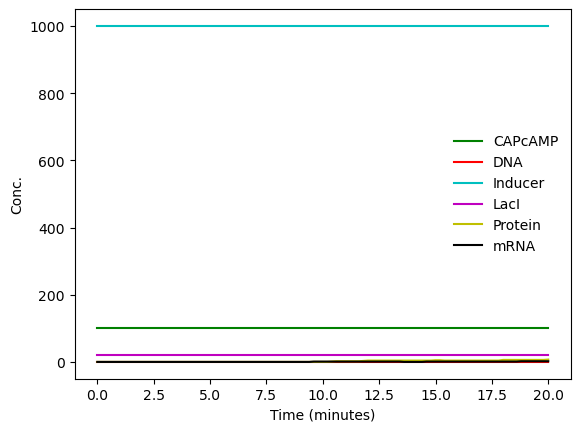

/opt/anaconda3/lib/python3.13/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


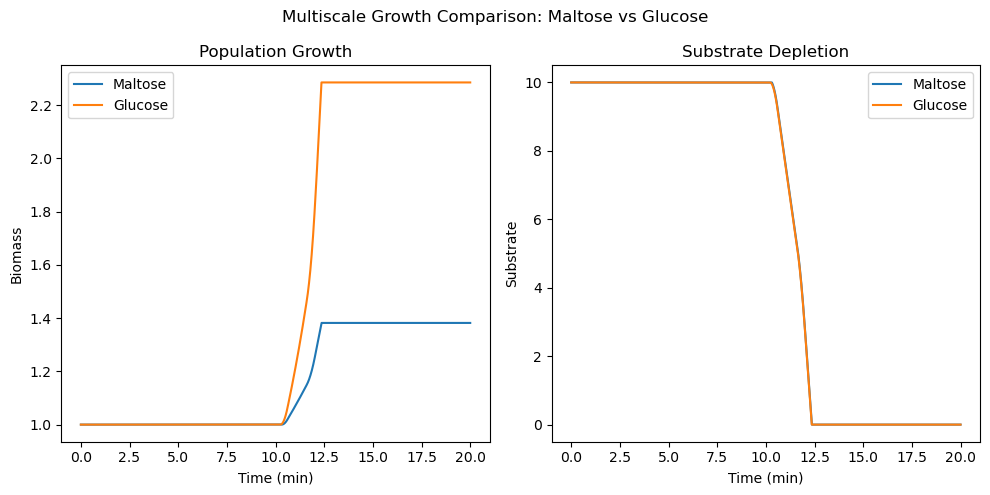

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from mobspy import *
from cobra.io import load_model

# ==========================================================
# 1) CRN: Lac Operon (stochastic gene expression)
# ==========================================================
DNA, mRNA, Protein, LacI, Inducer, CAPcAMP = BaseSpecies(6)

k_tx = 0.05 / u.min
k_tl = 0.5  / u.min
d_m  = 0.1  / u.min
d_p  = 0.01 / u.min

DNA >> DNA + mRNA [k_tx]
mRNA >> mRNA + Protein [k_tl]
mRNA >> Zero [d_m]
Protein >> Zero [d_p]

DNA(1)
mRNA(0)
Protein(0)
LacI(20)
Inducer(1000)
CAPcAMP(100)

sim_crn = Simulation(DNA | mRNA | Protein | LacI | Inducer | CAPcAMP)
sim_crn.duration = 20 * u.min
sim_crn.method = "stochastic"
sim_crn.run()

crn_time = np.array(sim_crn.results["Time"][0], dtype=float)
enzyme   = np.array(sim_crn.results["Protein"][0], dtype=float)

# ==========================================================
# 2) Multiscale Simulation Function
# ==========================================================
def run_simulation(CARBON_RXN):

    model = load_model("textbook")

    biomass_rxn = model.reactions.get_by_id("Biomass_Ecoli_core")
    biomass_rxn.lower_bound = 0

    # close all exchanges
    for rxn in model.exchanges:
        rxn.lower_bound = 0

    # minimal medium
    model.reactions.get_by_id(CARBON_RXN).lower_bound = -10
    model.reactions.EX_o2_e.lower_bound  = -20
    model.reactions.EX_nh4_e.lower_bound = -10
    model.reactions.EX_pi_e.lower_bound  = -10
    model.reactions.EX_h2o_e.lower_bound = -1000
    model.reactions.EX_h_e.lower_bound   = -1000

    dt = 0.001
    T  = 20
    time = np.arange(0, T, dt)

    biomass = 1.0
    substrate = 10.0

    biomass_trace = []
    substrate_trace = []

    for t in time:

        E_t = np.interp(t, crn_time, enzyme)

        vmax = 2.0 * E_t
        uptake_bound = min(vmax, substrate / dt)
        model.reactions.get_by_id(CARBON_RXN).lower_bound = -uptake_bound

        sol = model.optimize()

        if sol.status != "optimal":
            mu = 0
            uptake = 0
        else:
            mu = sol.objective_value
            uptake = -sol.fluxes[CARBON_RXN]

        biomass += mu * biomass * dt
        substrate -= uptake * dt
        substrate = max(substrate, 0)

        biomass_trace.append(biomass)
        substrate_trace.append(substrate)

    return time, biomass_trace, substrate_trace

# ==========================================================
# 3) Run both conditions
# ==========================================================
t, B_mal, S_mal = run_simulation("EX_mal__L_e")
_, B_glc, S_glc = run_simulation("EX_glc__D_e")

# ==========================================================
# 4) Visualization
# ==========================================================
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(t, B_mal, label="Maltose")
plt.plot(t, B_glc, label="Glucose")
plt.xlabel("Time (min)")
plt.ylabel("Biomass")
plt.title("Population Growth")
plt.legend()

plt.subplot(1,2,2)
plt.plot(t, S_mal, label="Maltose")
plt.plot(t, S_glc, label="Glucose")
plt.xlabel("Time (min)")
plt.ylabel("Substrate")
plt.title("Substrate Depletion")
plt.legend()

plt.suptitle("Multiscale Growth Comparison: Maltose vs Glucose")
plt.tight_layout()
plt.show()


Compiling model
Starting Simulator
Simulation is Over


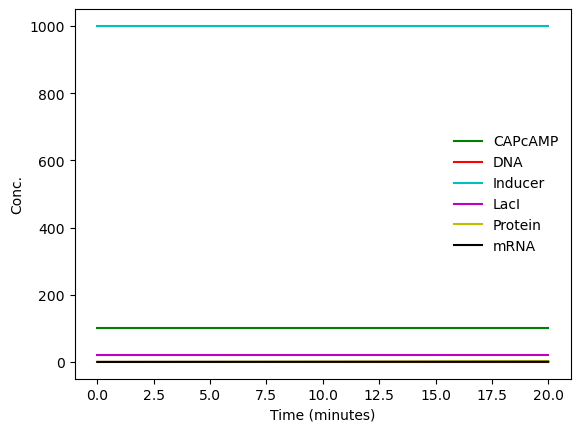

/opt/anaconda3/lib/python3.13/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


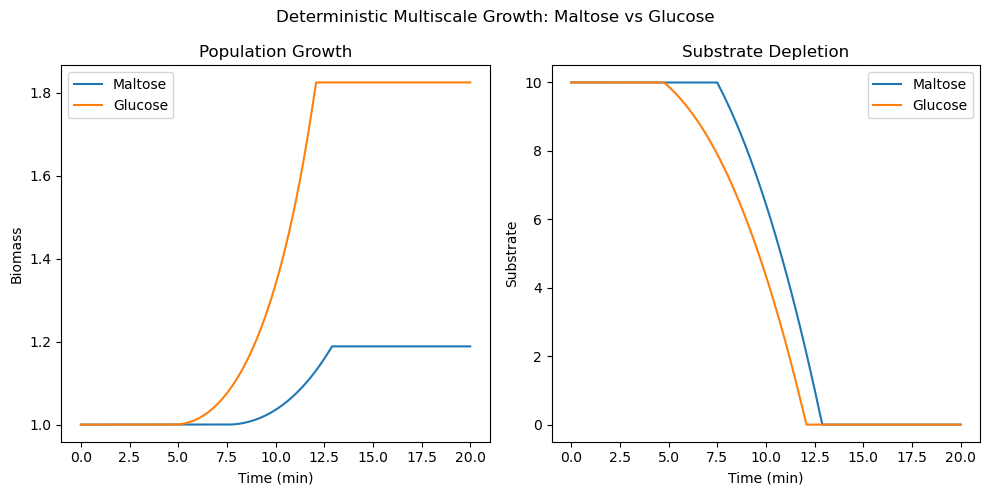

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mobspy import *
from cobra.io import load_model

# ==========================================================
# 1) CRN: Lac Operon (DETERMINISTIC gene expression)
# ==========================================================
DNA, mRNA, Protein, LacI, Inducer, CAPcAMP = BaseSpecies(6)

k_tx = 0.05 / u.min
k_tl = 0.5  / u.min
d_m  = 0.1  / u.min
d_p  = 0.01 / u.min

DNA >> DNA + mRNA [k_tx]
mRNA >> mRNA + Protein [k_tl]
mRNA >> Zero [d_m]
Protein >> Zero [d_p]

DNA(1)
mRNA(0)
Protein(0)
LacI(20)
Inducer(1000)
CAPcAMP(100)

sim_crn = Simulation(DNA | mRNA | Protein | LacI | Inducer | CAPcAMP)
sim_crn.duration = 20 * u.min
sim_crn.method = "deterministic"
sim_crn.run()

crn_time = np.array(sim_crn.results["Time"][0], dtype=float)
enzyme   = np.array(sim_crn.results["Protein"][0], dtype=float)

# ==========================================================
# 2) Multiscale Simulation Function
# ==========================================================
def run_simulation(CARBON_RXN):

    model = load_model("textbook")

    biomass_rxn = model.reactions.get_by_id("Biomass_Ecoli_core")
    biomass_rxn.lower_bound = 0

    for rxn in model.exchanges:
        rxn.lower_bound = 0

    model.reactions.get_by_id(CARBON_RXN).lower_bound = -10
    model.reactions.EX_o2_e.lower_bound  = -20
    model.reactions.EX_nh4_e.lower_bound = -10
    model.reactions.EX_pi_e.lower_bound  = -10
    model.reactions.EX_h2o_e.lower_bound = -1000
    model.reactions.EX_h_e.lower_bound   = -1000

    dt = 0.001
    T  = 20
    time = np.arange(0, T, dt)

    biomass = 1.0
    substrate = 10.0

    biomass_trace = []
    substrate_trace = []

    for t in time:

        E_t = np.interp(t, crn_time, enzyme)

        vmax = 2.0 * E_t
        uptake_bound = min(vmax, substrate / dt)
        model.reactions.get_by_id(CARBON_RXN).lower_bound = -uptake_bound

        sol = model.optimize()

        if sol.status != "optimal":
            mu = 0
            uptake = 0
        else:
            mu = sol.objective_value
            uptake = -sol.fluxes[CARBON_RXN]

        biomass += mu * biomass * dt
        substrate -= uptake * dt
        substrate = max(substrate, 0)

        biomass_trace.append(biomass)
        substrate_trace.append(substrate)

    return time, biomass_trace, substrate_trace

# ==========================================================
# 3) Run both carbon sources
# ==========================================================
t, B_mal, S_mal = run_simulation("EX_mal__L_e")
_, B_glc, S_glc = run_simulation("EX_glc__D_e")

# ==========================================================
# 4) Visualization
# ==========================================================
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(t, B_mal, label="Maltose")
plt.plot(t, B_glc, label="Glucose")
plt.xlabel("Time (min)")
plt.ylabel("Biomass")
plt.title("Population Growth")
plt.legend()

plt.subplot(1,2,2)
plt.plot(t, S_mal, label="Maltose")
plt.plot(t, S_glc, label="Glucose")
plt.xlabel("Time (min)")
plt.ylabel("Substrate")
plt.title("Substrate Depletion")
plt.legend()

plt.suptitle("Deterministic Multiscale Growth: Maltose vs Glucose")
plt.tight_layout()
plt.show()
